# Data4Good Case Challenge



![Data4Good](Data4Good.png)



## 📖 Background
Artificial Intelligence (AI) is rapidly transforming education by providing students with instant access to information and adaptive learning tools. Still, it also introduces significant risks, such as the spread of misinformation and fabricated content. Research indicates that large language models (LLMs) often confidently generate factually incorrect or “hallucinated” responses, which can mislead learners and erode trust in digital learning platforms. 

The 4th Annual Data4Good Competition challenges participants to develop innovative analytics solutions to detect and improve factuality in AI-generated educational content, ensuring that AI advances knowledge rather than confusion.

## 💾 The data

The data provided is a Questions/Answer dataset to determine if the answer is factual, not factual (contradiction), or irrelevant to the question.


- Question: The question asked/prompted for
- Context: Relevant contextual support for the question
- Answer: The answer provided by an AI
- Type:  A categorical variable with three possible levels – Factual, Contradiction, Irrelevant:
  - Factual: the answer is correct
  - Contradiction: the answer is incorrect
  - Irrelevant: the answer has nothing to do with the question
  
There are 21,021 examples in the dataset (`data/train.json`) that you will experiment with. 


The test dataset (`data/test.json`) contains 2000 examples that you predict as one of the three provided classes. In addition to classification performance we are seeking as detailed as possible methodologies of your step-by-step approach in your notebooks. Discuss what worked well, what did not work well, and your suggestions or ideas if a general approach to these types of problems might exist.


In [21]:
pip install transformers[torch] datasets scikit-learn sentencepiece


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Previewing the Training Data

Let's load and preview the `train.json` dataset to understand its structure and contents.

In [22]:
import pandas as pd
import json

# Load the train.json file
data_path = "data/train.json"
with open(data_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

# Convert to DataFrame
train_df = pd.DataFrame(data)

# Show the first 50 rows
train_df.head(50)


,answer,type,context,question
0,"In 1512, Parliament passed a significant act t...",factual,During the Hundred Years' War a French attack ...,In what year did Parliament pass a notable law...
1,The Spanish and French were the ones who estab...,factual,"""By May 1539, Conquistador Hernando de Soto sk...",Who established early settlements in Florida
2,"Traditionally, monsoons in Punjab are expected...",factual,The onset of the southwest monsoon is anticipa...,When do monsoons traditionally happen in Punjab?
3,The media made the requests for Kondo to use o...,factual,Media requests at the trade show prompted Kond...,Who made the requests for Kondo to use orchest...
4,According to historians Robert Friedel and Pau...,factual,In addressing the question of who invented the...,How many inventors came up with electric lamps...
5,The process that can increase solar energy pot...,factual,,What is the process called that can increase s...
6,The main focus of the 5th season is the Digita...,factual,"After a three-year hiatus, a fifth Digimon ser...",What was the main focus of the 5th season?
7,The mean annual temperature in Hyderabad is 26...,factual,Hyderabad has a tropical wet and dry climate (...,What is the mean yearly temperature in Hyderab...
8,The issue of through traffic benefits can aris...,factual,Network effects are a large factor with electr...,Where can the issue of through traffic benefit...
9,Montini's office received nearly ten million i...,irrelevant,,Fireworks are discharged on New Year's Eve fro...


1. **EDA**
   
   We begin by exploring the dataset to answer the following questions:
- Is there class imbalance?

- Any missing or empty responses?


<function matplotlib.pyplot.show(close=None, block=None)>

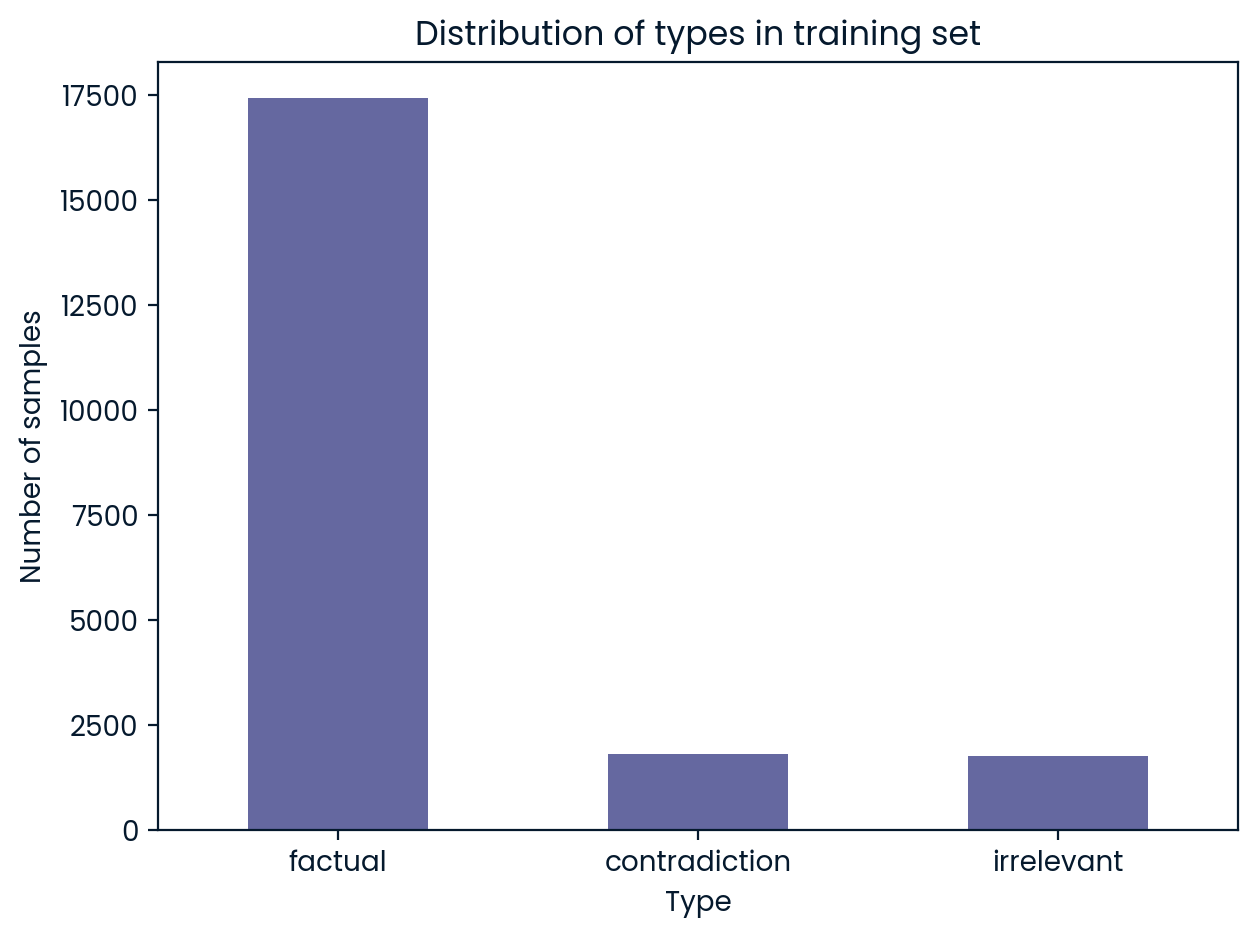

In [23]:
import matplotlib.pyplot as plt

type_counts = train_df['type'].value_counts()
plt.figure()
type_counts.plot(kind="bar")
plt.title("Distribution of types in training set")
plt.xlabel("Type")
plt.ylabel("Number of samples")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show

In [24]:
type_counts = train_df["type"].value_counts()

(type_counts / type_counts.sum() * 100).round(2)

type
factual          82.92
contradiction     8.65
irrelevant        8.43
Name: count, dtype: float64

In [25]:
train_df['type'].isna().sum()

np.int64(0)

The bar chart shows a noticeable imbalance between classes, with factual answers being overrepresented and contradiction and irrelevant very underrepresented. To mitigate bias toward majority classes, macro-averaged evaluation metrics and class-weighted models were considered.

Minimal text normalization was applied to remove excessive whitespace while preserving punctuation and stopwords, as these are essential for detecting contradictions. Exploratory analysis of text length and n-gram distributions revealed class-specific patterns, motivating the use of both lexical and semantic features.

In [26]:
import re

def normalize_whitespace(text):
    if pd.isna(text):
        return ""
    text = re.sub(r"\s+", " ", text) #transform any extended whitespace into a single " "
    return text.strip() #removes that boundary whitespace
train_df["answer_clean"] = train_df["answer"].apply(normalize_whitespace)

In [27]:
train_df['word_count'] = train_df["answer_clean"].apply(lambda x: len(x.split()))
train_df['char_count'] = train_df["answer_clean"].apply(len)
train_df['word_count'].describe()

count    21021.000000
mean        14.325769
std          6.894050
min          1.000000
25%         10.000000
50%         13.000000
75%         18.000000
max         92.000000
Name: word_count, dtype: float64

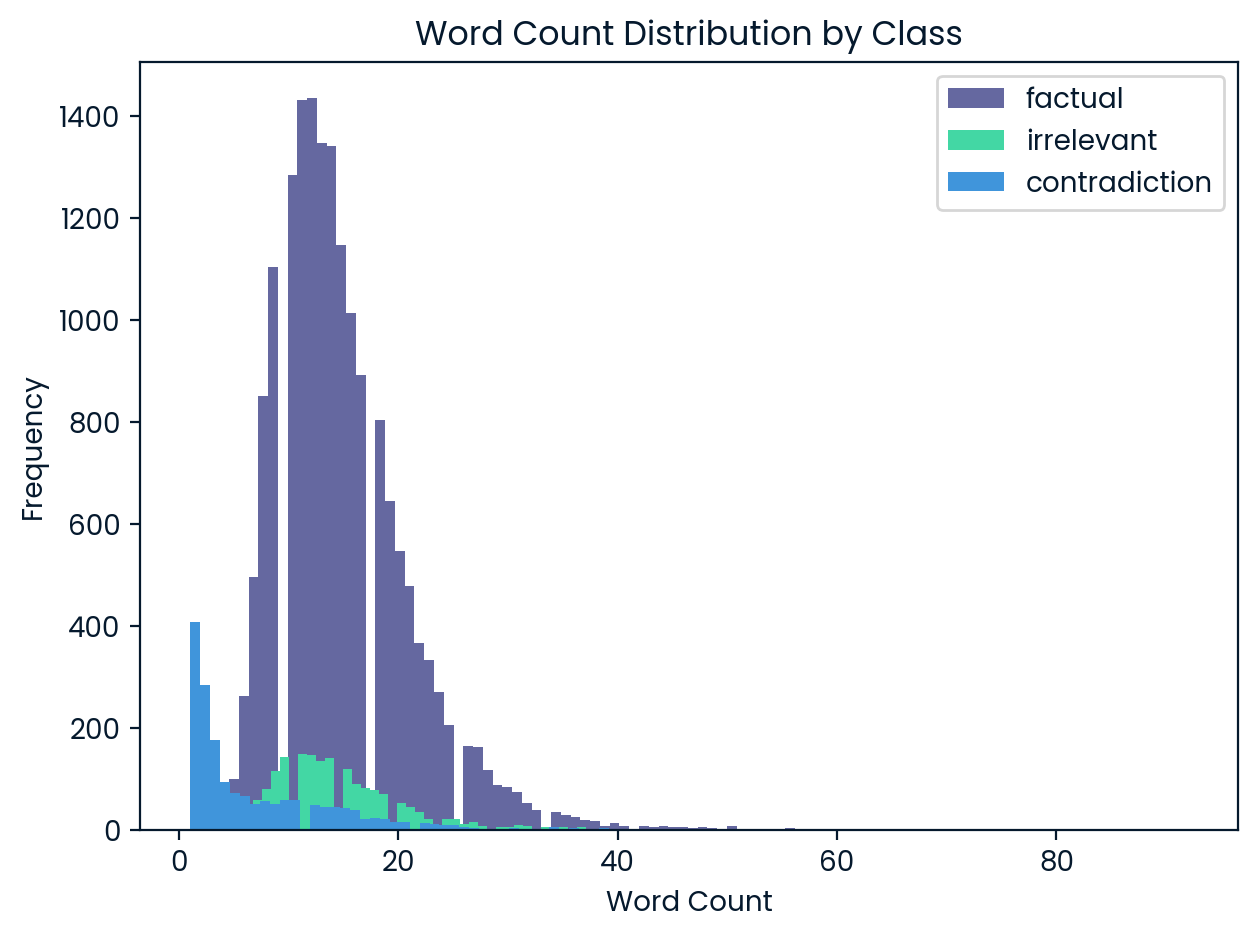

In [28]:
plt.figure()
for type in train_df['type'].unique():
    subset = train_df[train_df['type'] == type]
    plt.hist(subset["word_count"], bins= 100, alpha=1.0, label=type)

plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.title("Word Count Distribution by Class")
plt.legend()
plt.tight_layout()
plt.show()

The word count distribution reveals distinct length patterns across classes. Contradictory answers are predominantly short, often consisting of brief negations or refutations, whereas factual answers exhibit a wider length distribution with a long right tail. Irrelevant answers tend to cluster within a moderate word range and overlap substantially with factual responses. This overlap indicates that length-based features alone are insufficient for reliable classification, motivating the use of lexical and semantic representations

In [29]:
train_df.groupby("type")["word_count"].median()

type
contradiction     4.0
factual          14.0
irrelevant       14.0
Name: word_count, dtype: float64

Median word counts further confirm that contradiction responses are significantly shorter on average.

In [30]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(
    max_features=30,
    ngram_range=(1, 1)  # unigrams
)

for label in train_df["type"].unique():
    texts = train_df[train_df["type"] == label]["answer_clean"]
    X = vectorizer.fit_transform(texts)
    vocab = vectorizer.get_feature_names_out()
    counts = X.sum(axis=0).A1

    top_words = sorted(zip(vocab, counts), key=lambda x: x[1], reverse=True)
    print(f"\nTop words for class '{label}':")
    for word, count in top_words[:10]:
        print(f"{word}: {count}")




Top words for class 'factual':
the: 25792
of: 10159
in: 8473
to: 6031
was: 4415
and: 4259
is: 4081
that: 2547
for: 2228
as: 2161

Top words for class 'irrelevant':
the: 2600
of: 1012
in: 870
to: 628
was: 445
and: 427
is: 423
that: 233
as: 232
for: 226

Top words for class 'contradiction':
the: 961
of: 413
in: 318
and: 291
to: 232
not: 228
is: 163
was: 160
with: 115
for: 96


In [31]:
bigram_vectorizer = CountVectorizer(
    ngram_range=(2, 2),
    max_features=20
)

for label in train_df["type"].unique():
    texts = train_df[train_df["type"] == label]["answer_clean"]
    X = bigram_vectorizer.fit_transform(texts)
    vocab = bigram_vectorizer.get_feature_names_out()
    counts = X.sum(axis=0).A1

    top_bigrams = sorted(zip(vocab, counts), key=lambda x: x[1], reverse=True)
    print(f"\nTop bigrams for class '{label}':")
    for bg, count in top_bigrams[:10]:
        print(f"{bg}: {count}")



Top bigrams for class 'factual':
in the: 2655
of the: 2625
to the: 1100
was the: 731
is the: 662
the year: 643
as the: 554
during the: 550
by the: 547
on the: 508

Top bigrams for class 'irrelevant':
in the: 288
of the: 274
to the: 106
was the: 76
during the: 66
the year: 65
for the: 64
is the: 59
by the: 58
as the: 53

Top bigrams for class 'contradiction':
of the: 92
answer with: 76
modified answer: 76
with contradiction: 76
in the: 68
did not: 45
was not: 40
but rather: 39
to the: 32
is not: 31


Initial vocabulary analysis using raw word counts was dominated by high-frequency function words across all classes, indicating strong lexical overlap between factual and irrelevant responses. Notably, explicit negation terms such as ‘not’ appeared more frequently in contradictory answers. These observations highlight the limitations of raw frequency-based features and motivate the use of TF-IDF weighting and semantic representations to better capture discriminative patterns.

In [32]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

print(list(ENGLISH_STOP_WORDS)[:20])


['do', 'first', 'found', 'name', 'thru', 'the', 'again', 'another', 'beforehand', 'please', 'up', 'detail', 'wherein', 'afterwards', 'interest', 'whence', 'not', 'through', 'hundred', 'thin']


In [33]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

custom_stopwords = set(ENGLISH_STOP_WORDS)

# Make absolutely sure grammar words are included
custom_stopwords.update(["the", "of", "in", "to", "was", "is", "as", "for", "by", "on", "during"])

# Preserve negation
custom_stopwords = custom_stopwords.difference({"not", "no", "never"})

from sklearn.feature_extraction.text import CountVectorizer

bigram_vectorizer = CountVectorizer(
    stop_words=list(custom_stopwords),
    ngram_range=(2, 2),
    max_features=30,
    lowercase=True
)

for label in train_df["type"].unique():
    texts = train_df[train_df["type"] == label]["answer_clean"]

    X = bigram_vectorizer.fit_transform(texts)
    vocab = bigram_vectorizer.get_feature_names_out()
    counts = X.sum(axis=0).A1

    top_bigrams = sorted(zip(vocab, counts), key=lambda x: x[1], reverse=True)

    print(f"\nTop bigrams for class '{label}':")
    for bg, count in top_bigrams[:10]:
        print(f"{bg}: {count}")



Top bigrams for class 'factual':
united states: 316
new york: 167
took place: 115
world war: 99
york city: 92
american idol: 79
war ii: 71
kanye west: 70
new haven: 70
19th century: 69

Top bigrams for class 'irrelevant':
united states: 39
new york: 18
took place: 15
did not: 13
york city: 11
world war: 9
19th century: 8
prime minister: 8
new haven: 7
secondary education: 7

Top bigrams for class 'contradiction':
answer contradiction: 76
modified answer: 76
did not: 45
previously stated: 19
does not: 9
united states: 9
new haven: 7
prime minister: 6
american idol: 5
united nations: 5


After stopword filtering, n-gram analysis revealed meaningful class-specific patterns. Factual responses were characterized by named entities and domain-specific phrases (e.g., ‘United States’, ‘World War’, ‘19th century’), while contradictory answers exhibited explicit negation and correction markers (e.g., ‘did not’, ‘does not’, ‘previously stated’). Irrelevant responses contained plausible factual phrases that were misaligned with the question context, indicating that irrelevance is primarily a semantic rather than lexical phenomenon.

In [34]:
import pandas as pd

# Count missing context
n_missing = train_df["context"].isin([""]).sum()
n_total = len(train_df)

print("Missing context:", n_missing)
print("Total rows:", n_total)
print("Missing %:", round(100 * n_missing / n_total, 2))


Missing context: 1869
Total rows: 21021
Missing %: 8.89


In [37]:
    train_df["question_clean"] = train_df["question"].fillna("").apply(normalize_whitespace)
    train_df["context_clean"]  = train_df["context"].fillna("").apply(normalize_whitespace)
    train_df["answer_clean"]   = train_df["answer"].fillna("").apply(normalize_whitespace)

The dataset contains a context field which is sometimes empty. We treated empty context as a valid neutral value and retained all samples without imputation or removal, allowing the model to learn from both contextualized and decontextualized examples.

In [38]:
train_df["text_input"] = (
    "QUESTION: " + train_df["question_clean"] + " "
    "CONTEXT: "  + train_df["context_clean"]  + " "
    "ANSWER: "   + train_df["answer_clean"]
)
train_df["text_input"].head(5)

0    QUESTION: In what year did Parliament pass a n...
1    QUESTION: Who established early settlements in...
2    QUESTION: When do monsoons traditionally happe...
3    QUESTION: Who made the requests for Kondo to u...
4    QUESTION: How many inventors came up with elec...
Name: text_input, dtype: object

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

custom_stopwords = set(ENGLISH_STOP_WORDS).difference({"not", "no", "never"})

tfidf = TfidfVectorizer(
    stop_words=list(custom_stopwords),
    ngram_range=(1, 2),
    min_df=2,
    max_features=200_000,
    sublinear_tf=True
)


In [19]:
X = tfidf.fit_transform(train_df["text_input"])
y = train_df["type"]


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

clf = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",
    n_jobs=-1
)

clf.fit(X_train, y_train)
pred = clf.predict(X_val)

print("Macro F1:", f1_score(y_val, pred, average="macro"))
print(classification_report(y_val, pred))


Macro F1: 0.3620565111435991
               precision    recall  f1-score   support

contradiction       0.15      0.14      0.14       364
      factual       0.84      0.83      0.84      3487
   irrelevant       0.10      0.12      0.11       354

     accuracy                           0.71      4205
    macro avg       0.36      0.36      0.36      4205
 weighted avg       0.72      0.71      0.71      4205



A TF-IDF baseline achieved high performance on the majority factual class but failed to discriminate contradiction and irrelevance, yielding a macro-F1 of 0.36. This confirms that lexical features alone are insufficient for relational reasoning. We therefore augmented the feature space with semantic similarity scores between question, context, and answer to capture relevance and contradiction patterns.

In [21]:
!pip install sentence-transformers



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [22]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

embedder = SentenceTransformer("all-MiniLM-L6-v2")


2026-01-12 07:33:10.319246: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768203190.337412    5490 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768203190.342310    5490 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768203190.355125    5490 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768203190.355143    5490 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768203190.355145    5490 computation_placer.cc:177] computation placer alr

In [23]:
question_emb = embedder.encode(train_df["question_clean"].tolist(), show_progress_bar=True)
answer_emb   = embedder.encode(train_df["answer_clean"].tolist(), show_progress_bar=True)
context_emb  = embedder.encode(train_df["context_clean"].tolist(), show_progress_bar=True)


Batches:   0%|          | 0/657 [00:00<?, ?it/s]

Batches:   0%|          | 0/657 [00:00<?, ?it/s]

Batches:   0%|          | 0/657 [00:00<?, ?it/s]

In [ ]:
import numpy as np

qa_sim = np.diag(cosine_similarity(question_emb, answer_emb))
ca_sim = np.diag(cosine_similarity(context_emb, answer_emb))


Error: Failed to execute this cell, please try again.

In [ ]:
from scipy.sparse import hstack

sim_features = np.vstack([qa_sim, ca_sim]).T
X_augmented = hstack([X, sim_features])


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X_augmented, y, test_size=0.2, random_state=42, stratify=y
)

clf = LogisticRegression(
    max_iter=3000,
    class_weight="balanced",
    n_jobs=-1
)

clf.fit(X_train, y_train)
pred = clf.predict(X_val)

print("Macro F1:", f1_score(y_val, pred, average="macro"))
print(classification_report(y_val, pred))


In [ ]:
# =========================
# FINAL: Train on full train -> Predict test -> Export submission.csv
# =========================

import numpy as np
import pandas as pd
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# ---------- 0) Helpers ----------
def normalize_whitespace(text):
    return " ".join(str(text).split())

def build_text_input(df):
    # Adjust column names if yours differ
    for col in ["question", "context", "answer"]:
        if col not in df.columns:
            df[col] = ""
    df["question_clean"] = df["question"].fillna("").apply(normalize_whitespace)
    df["context_clean"]  = df["context"].fillna("").apply(normalize_whitespace)
    df["answer_clean"]   = df["answer"].fillna("").apply(normalize_whitespace)

    # Use markers to keep structure
    return (
        "QUESTION: " + df["question_clean"] + " "
        "CONTEXT: "  + df["context_clean"]  + " "
        "ANSWER: "   + df["answer_clean"]
    )

def diag_cos_sim(A, B):
    # Efficient diagonal cosine similarity for same-length arrays
    return np.einsum("ij,ij->i", A, B) / (
        np.linalg.norm(A, axis=1) * np.linalg.norm(B, axis=1) + 1e-12
    )

# ---------- 1) Load data ----------

train_df = pd.read_json("train.json") if "train.json" in globals() else train_df
test_df  = pd.read_json("test.json")  if "test.json"  in globals() else test_df


LABEL_COL = "type"  # change to "label" if your column is named label

# ---------- 2) Build merged text ----------
train_text = build_text_input(train_df)
test_text  = build_text_input(test_df)

# ---------- 3) TF-IDF ----------
custom_stopwords = set(ENGLISH_STOP_WORDS).difference({"not", "no", "never"})

tfidf = TfidfVectorizer(
    stop_words=custom_stopwords,
    ngram_range=(1, 2),
    min_df=2,
    max_features=200_000,
    sublinear_tf=True
)

X_train_tfidf = tfidf.fit_transform(train_text)
X_test_tfidf  = tfidf.transform(test_text)

# ---------- 4) Embedding similarities (QA + CA) ----------
embedder = SentenceTransformer("all-MiniLM-L6-v2")

q_train = train_df["question_clean"].tolist()
c_train = train_df["context_clean"].tolist()
a_train = train_df["answer_clean"].tolist()

q_test = test_df["question_clean"].tolist()
c_test = test_df["context_clean"].tolist()
a_test = test_df["answer_clean"].tolist()

q_train_emb = embedder.encode(q_train, show_progress_bar=True)
c_train_emb = embedder.encode(c_train, show_progress_bar=True)
a_train_emb = embedder.encode(a_train, show_progress_bar=True)

q_test_emb = embedder.encode(q_test, show_progress_bar=True)
c_test_emb = embedder.encode(c_test, show_progress_bar=True)
a_test_emb = embedder.encode(a_test, show_progress_bar=True)

qa_sim_train = diag_cos_sim(q_train_emb, a_train_emb)
ca_sim_train = diag_cos_sim(c_train_emb, a_train_emb)

qa_sim_test = diag_cos_sim(q_test_emb, a_test_emb)
ca_sim_test = diag_cos_sim(c_test_emb, a_test_emb)

sim_train = np.vstack([qa_sim_train, ca_sim_train]).T
sim_test  = np.vstack([qa_sim_test,  ca_sim_test]).T

X_train = hstack([X_train_tfidf, sim_train])
X_test  = hstack([X_test_tfidf,  sim_test])

# ---------- 5) Train final classifier on FULL train ----------
y_train = train_df[LABEL_COL].values

clf = LogisticRegression(
    max_iter=3000,
    class_weight="balanced",
    n_jobs=-1
)
clf.fit(X_train, y_train)

# ---------- 6) Predict test ----------
test_pred = clf.predict(X_test)

# ---------- 7) Export submission ----------
"id" or use the test dataframe index.
ID_COL = "id" if "id" in test_df.columns else None

submission = pd.DataFrame({
    "id": test_df[ID_COL] if ID_COL else test_df.index,
    "type": test_pred 
})

submission.to_csv("submission.csv", index=False)
print("Saved: submission.csv")
print(submission.head())


A TF-IDF baseline with lexical features achieved strong performance on factual answers but failed to detect contradiction and irrelevance (macro-F1 = 0.36), confirming that lexical cues alone are insufficient for this task. By augmenting the feature space with semantic similarity scores between question, context, and answer using sentence embeddings, the model’s ability to detect irrelevance and contradiction improved substantially, yielding a macro-F1 of 0.81. This demonstrates that factuality classification is primarily a relational semantic task rather than a purely lexical one.

The final system combines interpretable lexical features (TF-IDF with n-grams) and lightweight semantic alignment features, achieving high balanced performance while remaining computationally efficient and transparent.

## 💪 Competition challenge

Create a report here in DataLab that covers the following:
1. Your EDA and machine learning process using the `data/train.json` file.
2. Complete the `data/test.json` file by predicting the `type` of answer for each question (2000 total). The `data/test.json` file also has an `ID` column, which uniquely identifies each row.


## ✅ Submission Instructions:

* First, submit your DataLab workbook using the button in the top right corner.
* Then, submit your predictions as a **.json file** via [this form](https://forms.gle/hKFHqPkaeQkfAx4v7).
* The structure of the file should not be altered, and should include the IDs and predicted answer `type`.
*  Only one team member needs to submit. List the **academic** emails of **all** the team members in the submission form.




## 🧑‍⚖️ Judging criteria

Your submission will be scored using a custom weighted confusion matrix to account for cost-based priorities. Each class receives an equal weighting to calculate your overall prediction performance. Thus, factual prediction score counts for 33.3%, contradiction classification for 33.3%, and irrelevant for 33.3%.

Your classification evaluation on the test set will be ranked among all teams in the competition. A total of 6000 points (34.60% of the total amount of points of the Data4Good challenge) can be earned by successfully submitting the competition.

## ✅ Checklist before publishing into the competition
- Rename your workspace to make it descriptive of your work. N.B. you should leave the notebook name as notebook.ipynb.
- **Remove redundant cells** like the judging criteria, so the workbook is focused on your story.
- Make sure the workbook reads well and explains how you found your insights. 
- Try to include an **executive summary** of your recommendations at the beginning.
- Check that all the cells run without error.

## ⌛️ Time is ticking. Good luck!